In [ ]:
import kagglehub

data_path = kagglehub.dataset_download('khanfashee/nih-chest-x-ray-14-224x224-resized')
print('Data source import complete.')


Data source import complete.


# DannyNet - Keras Fast Edition ⚡

**Using tf.data for FAST data loading!**

✅ All DannyNet improvements (Focal Loss, AdamW, patient splits, optimal thresholds)
✅ tf.data pipeline (parallel loading, prefetching)

**IMPORTANT**

**Must add dataset as input**

https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized

In [ ]:
# Protobuf compatibility fix (if needed)
import google.protobuf.message_factory as mf
if not hasattr(mf.MessageFactory, "GetPrototype"):
    mf.MessageFactory.GetPrototype = lambda *args, **kwargs: None


In [ ]:
import os
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve
import time

print("="*60)
print("DANNYNET - KERAS FAST EDITION")
print("="*60)

# Configuration
CONFIG = {
    "model": "dannynet_keras_fast",
    "batch_size": 64,
    "learning_rate": 5e-5,
    "epochs": 25,
    "patience": 5,
    "seed": 42,
    "image_size": 224,
    "prefetch_buffer": tf.data.AUTOTUNE,
    "num_parallel_calls": tf.data.AUTOTUNE,
}

# Set seeds for reproducibility
np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])

print(f"\n✓ Configuration loaded")
print(f"  Using tf.data for FAST parallel data loading")

2025-12-19 00:05:57.925722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766102758.095201      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766102758.143133      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766102758.532912      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766102758.532965      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766102758.532968      23 computation_placer.cc:177] computation placer alr

DANNYNET - KERAS FAST EDITION

✓ Configuration loaded
  Using tf.data for FAST parallel data loading


## Load Data

In [4]:
# Data paths
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")

print(f"Loading data from: {data_path}")

# Load CSV
df = pd.read_csv(csv_file)
print(f"✓ Loaded CSV: {len(df)} rows")

# Find images
images_folder = os.path.join(data_path, "images-224", "images-224")

all_image_paths = {}
if os.path.exists(images_folder):
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
    all_image_paths = {f: os.path.join(images_folder, f) for f in image_files}
    print(f"✓ Found {len(all_image_paths)} images")
else:
    raise FileNotFoundError(f"Images not found at {images_folder}")

# Map paths
df['Path'] = df['Image Index'].map(all_image_paths.get)
df = df.dropna(subset=['Path'])
print(f"✓ After filtering: {len(df)} images")

# Extract disease labels
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0 and x != 'No Finding']
print(f"\n✓ Diseases ({len(all_labels)}): {all_labels}")

# Create binary columns
for label in all_labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

print(f"✓ Dataset shape: {df.shape}")

Loading data from: /kaggle/input/nih-chest-x-ray-14-224x224-resized
✓ Loaded CSV: 112120 rows
✓ Found 112120 images
✓ After filtering: 112120 images

✓ Diseases (14): [np.str_('Atelectasis'), np.str_('Cardiomegaly'), np.str_('Consolidation'), np.str_('Edema'), np.str_('Effusion'), np.str_('Emphysema'), np.str_('Fibrosis'), np.str_('Hernia'), np.str_('Infiltration'), np.str_('Mass'), np.str_('Nodule'), np.str_('Pleural_Thickening'), np.str_('Pneumonia'), np.str_('Pneumothorax')]
✓ Dataset shape: (112120, 27)


## Patient-Level Splitting

In [5]:
print("="*60)
print("PATIENT-LEVEL SPLITTING")
print("="*60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients)}")

train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=CONFIG["seed"]
)

train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=CONFIG["seed"]
)

train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"✓ Train: {len(train_df)} images from {len(train_patients)} patients")
print(f"✓ Val: {len(val_df)} images from {len(val_patients)} patients")
print(f"✓ Test: {len(test_df)} images from {len(test_patients)} patients")

PATIENT-LEVEL SPLITTING
Total unique patients: 30805
✓ Train: 103847 images from 28618 patients
✓ Val: 5974 images from 1570 patients
✓ Test: 2299 images from 617 patients


## Fast Data Pipeline (tf.data)

**This is the KEY to speed!** tf.data enables:
- Parallel image loading (uses all CPU cores)
- Prefetching (loads next batch while GPU trains)
- GPU-accelerated augmentation

In [6]:
print("="*60)
print("FAST DATA PIPELINE (tf.data)")
print("="*60)

def preprocess_image(image, is_training=False):
    """Preprocess with optional augmentation"""
    image = tf.image.resize(image, [CONFIG["image_size"], CONFIG["image_size"]])

    if is_training:
        # DannyNet augmentations
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

        # Random crop and resize
        shape = tf.shape(image)
        crop_size = tf.random.uniform([], minval=0.8, maxval=1.0)
        new_h = tf.cast(tf.cast(shape[0], tf.float32) * crop_size, tf.int32)
        new_w = tf.cast(tf.cast(shape[1], tf.float32) * crop_size, tf.int32)
        image = tf.image.random_crop(image, [new_h, new_w, 3])
        image = tf.image.resize(image, [CONFIG["image_size"], CONFIG["image_size"]])

    # ImageNet normalization
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)

    return image

def load_image_and_label(path, label, is_training=False):
    """Load and preprocess image"""
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = preprocess_image(image, is_training=is_training)
    return image, label

def create_dataset(dataframe, is_training=False, shuffle=False):
    """Create tf.data.Dataset"""
    paths = dataframe['Path'].values
    labels = dataframe[all_labels].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=CONFIG["seed"])

    # Parallel loading + prefetching = FAST!
    dataset = dataset.map(
        lambda p, l: load_image_and_label(p, l, is_training=is_training),
        num_parallel_calls=CONFIG["num_parallel_calls"]
    )

    dataset = dataset.batch(CONFIG["batch_size"])
    dataset = dataset.prefetch(CONFIG["prefetch_buffer"])

    return dataset

print("Creating datasets (INSTANT with tf.data)...")
start_time = time.time()

train_dataset = create_dataset(train_df, is_training=True, shuffle=True)
val_dataset = create_dataset(val_df, is_training=False, shuffle=False)
test_dataset = create_dataset(test_df, is_training=False, shuffle=False)

print(f"✓ Datasets created in {time.time() - start_time:.1f}s")
print(f"  Train: {len(train_df)} images")
print(f"  Val: {len(val_df)} images")
print(f"  Test: {len(test_df)} images")

FAST DATA PIPELINE (tf.data)
Creating datasets (INSTANT with tf.data)...


I0000 00:00:1766102773.638710      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✓ Datasets created in 2.5s
  Train: 103847 images
  Val: 5974 images
  Test: 2299 images


## Focal Loss

In [7]:
print("="*60)
print("FOCAL LOSS")
print("="*60)

def focal_loss(alpha=1.0, gamma=2.0):
    """Focal Loss - fast Keras backend version"""
    def loss_fn(y_true, y_pred):
        import tensorflow.keras.backend as K

        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        bce = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = K.pow(1.0 - p_t, gamma)

        return K.mean(alpha * focal_term * bce)

    return loss_fn

print("✓ Focal Loss defined (alpha=1, gamma=2)")

FOCAL LOSS
✓ Focal Loss defined (alpha=1, gamma=2)


## Build Model

In [ ]:
print("="*60)
print("MODEL")
print("="*60)

base_model = MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIG["image_size"], CONFIG["image_size"], 3),
    pooling='avg'
)

x = base_model.output
predictions = Dense(len(all_labels), activation='sigmoid', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)

print(f"✓ MobileNetV3Large loaded ({model.count_params():,} params)")

MODEL
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✓ DenseNet121 loaded (3,009,806 params)


## Compile Model

In [9]:
optimizer = AdamW(learning_rate=CONFIG["learning_rate"], weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(alpha=1.0, gamma=2.0),
    metrics=['binary_accuracy']
)

print("✓ Model compiled with AdamW + Focal Loss")

✓ Model compiled with AdamW + Focal Loss


## Setup Callbacks

In [ ]:
output_dir = '/kaggle/working/' if os.path.exists('/kaggle/working/') else './'
os.makedirs(output_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    os.path.join(output_dir, 'best_weights.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stop]
print("✓ Callbacks configured")

✓ Callbacks configured
(64, 224, 224, 3)
(64, 224, 224, 3)
(64, 224, 224, 3)
(64, 224, 224, 3)
(64, 224, 224, 3)


## Train Model 🚀

In [11]:
print("="*60)
print("TRAINING")
print("="*60)

history = model.fit(
    train_dataset,
    epochs=CONFIG["epochs"],
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")

TRAINING
Epoch 1/25


I0000 00:00:1766102804.066822      62 service.cc:152] XLA service 0x7a44080030e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766102804.066862      62 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766102808.622275      62 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-19 00:06:58.333630: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 00:06:58.524600: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 00:06:59.031152: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accur

1622/1623 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - binary_accuracy: 0.9299 - loss: 0.0588

2025-12-19 00:11:55.728547: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 00:11:55.913964: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 00:11:56.372887: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-19 00:11:56.571681: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1623/1623 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - binary_accuracy: 0.9299 - loss: 0.0588
Epoch 1: val_loss improved from inf to 0.05479, saving model to /kaggle/working/best_weights.weights.h5
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 380s 199ms/step - binary_accuracy: 0.9299 - loss: 0.0588 - val_binary_accuracy: 0.9446 - val_loss: 0.0548 - learning_rate: 5.0000e-05
Epoch 2/25
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - binary_accuracy: 0.9522 - loss: 0.0426
Epoch 2: val_loss improved from 0.05479 to 0.04617, saving model to /kaggle/working/best_weights.weights.h5
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 193s 119ms/step - binary_accuracy: 0.9522 - loss: 0.0426 - val_binary_accuracy: 0.9487 - val_loss: 0.0462 - learning_rate: 5.0000e-05
Epoch 3/25
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - binary_accuracy: 0.9527 - loss: 0.0408
Epoch 3: val_loss improved from 0.04617 to 0.04390, saving model to /kaggle/working/best_weights.weights.h5
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 193s 119ms/step - binary_accuracy: 0.95

## Plot Training History

✓ Saved: training_history.png


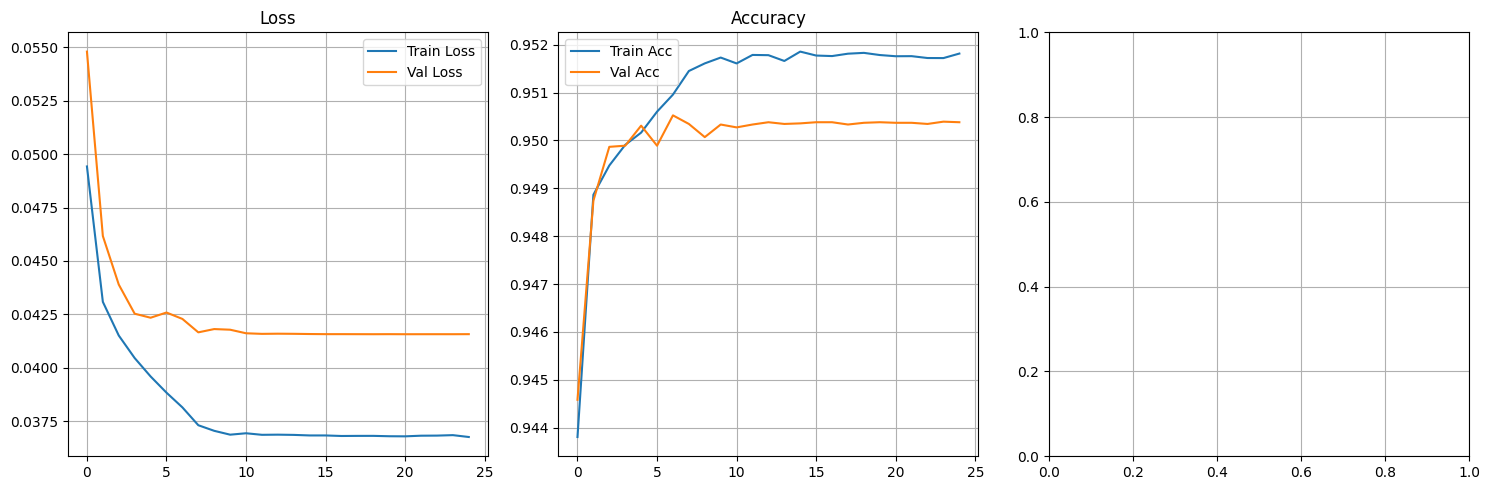

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Acc')
plt.plot(history.history['val_binary_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_history.png'), dpi=150)
print(f"✓ Saved: training_history.png")
plt.show()

## Evaluation

In [13]:
print("="*60)
print("EVALUATION")
print("="*60)

model.load_weights(os.path.join(output_dir, 'best_weights.weights.h5'))
print("✓ Loaded best weights")

pred_y = model.predict(test_dataset, verbose=1)
y_true = test_df[all_labels].values

print(f"\nPredictions: {pred_y.shape}")
print(f"Labels: {y_true.shape}")

EVALUATION
✓ Loaded best weights
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 340ms/step

Predictions: (2299, 14)
Labels: (2299, 14)


## Optimal Thresholds

In [14]:
print("="*60)
print("OPTIMAL THRESHOLDS")
print("="*60)

optimal_thresholds = []
for i, disease in enumerate(all_labels):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], pred_y[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5
    optimal_thresholds.append(best_threshold)
    print(f"{disease:25s} Threshold: {best_threshold:.3f}")

OPTIMAL THRESHOLDS
Atelectasis               Threshold: 0.389
Cardiomegaly              Threshold: 0.338
Consolidation             Threshold: 0.328
Edema                     Threshold: 0.337
Effusion                  Threshold: 0.426
Emphysema                 Threshold: 0.310
Fibrosis                  Threshold: 0.399
Hernia                    Threshold: 0.235
Infiltration              Threshold: 0.389
Mass                      Threshold: 0.347
Nodule                    Threshold: 0.322
Pleural_Thickening        Threshold: 0.293
Pneumonia                 Threshold: 0.230
Pneumothorax              Threshold: 0.385


## Per-Disease Metrics

In [15]:
print("="*60)
print("METRICS")
print("="*60)

auc_scores = []
f1_scores_list = []

for i, disease in enumerate(all_labels):
    try:
        auc_score = roc_auc_score(y_true[:, i], pred_y[:, i])
    except:
        auc_score = 0.0
    auc_scores.append(auc_score)

    pred_binary = (pred_y[:, i] > optimal_thresholds[i]).astype(int)
    f1 = f1_score(y_true[:, i], pred_binary)
    f1_scores_list.append(f1)

    print(f"{disease:25s} AUC: {auc_score:.4f} | F1: {f1:.4f}")

print("\n" + "="*60)
print(f"AVERAGE AUC: {np.mean(auc_scores):.4f}")
print(f"AVERAGE F1:  {np.mean(f1_scores_list):.4f}")
print("="*60)

METRICS
Atelectasis               AUC: 0.7815 | F1: 0.3724
Cardiomegaly              AUC: 0.9128 | F1: 0.4686
Consolidation             AUC: 0.7584 | F1: 0.2330
Edema                     AUC: 0.8535 | F1: 0.2763
Effusion                  AUC: 0.8877 | F1: 0.5968
Emphysema                 AUC: 0.9350 | F1: 0.4458
Fibrosis                  AUC: 0.7891 | F1: 0.0870
Hernia                    AUC: 0.9891 | F1: 0.3333
Infiltration              AUC: 0.6740 | F1: 0.3736
Mass                      AUC: 0.8447 | F1: 0.4071
Nodule                    AUC: 0.6760 | F1: 0.1922
Pleural_Thickening        AUC: 0.7632 | F1: 0.2157
Pneumonia                 AUC: 0.7040 | F1: 0.0553
Pneumothorax              AUC: 0.8485 | F1: 0.3545

AVERAGE AUC: 0.8155
AVERAGE F1:  0.3151


## ROC Curves


✓ Saved: roc_curves.png


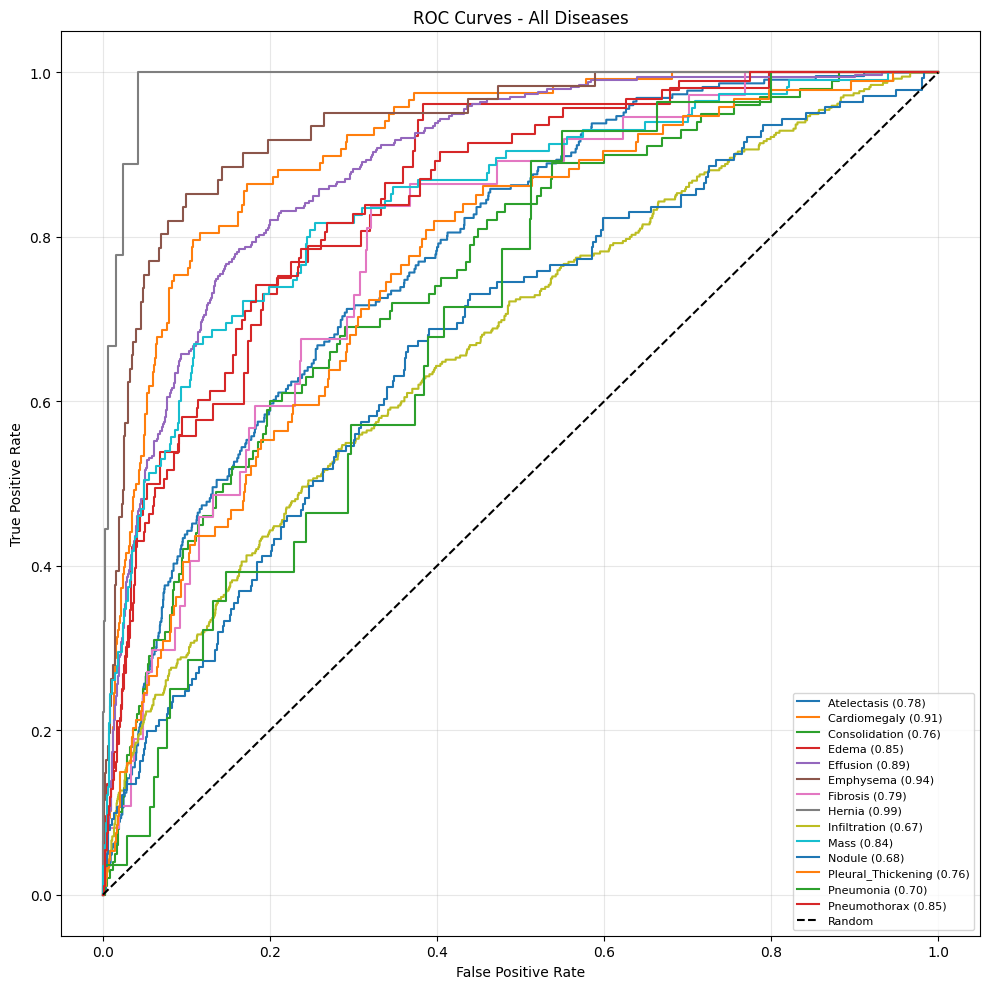


DONE! ⚡


In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, disease in enumerate(all_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], pred_y[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{disease} ({roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - All Diseases')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curves.png'), dpi=150)
print(f"\n✓ Saved: roc_curves.png")
plt.show()

print("\n" + "="*60)
print("DONE! ⚡")
print("="*60)